# Session 5 - Document classification and prediction - questions from class

## You have been asked to build a document classifier that helps your communication staff determine the audience for incoming news articles. 

They have provided you with some test data that has the article and their determination of the audience (Executive, Staff, Everyone).  They also included the number of "Likes" the story got because they think that might be helpful in determining who should read things.  

Okay, go. 

In [2]:
# set up the environment
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
pathname = "/Users/sancan/Google Drive/Rockhurst/2017/FallA-TM/supporting_files/" #where to get/put files
pd.set_option('display.max_colwidth', 15000) #important for getting all the text


In [3]:
# New York Times
newsdf = pd.read_csv("nytnews.csv", index_col = 0)  

print(newsdf.shape)
print(list(newsdf))

(3848, 7)
['description', 'headline', 'url', 'text', 'cleantext', 'Audience', 'likes']


In [4]:
newsdf.head()

description  \
date                                                                                                                                                                                              
2013-01-01             Ending a climactic showdown in the final hours of the 112th Congress, the House sent to President Obama legislation to avert big income tax increases on most Americans.   
2013-01-01                        A report on nearly three million people found that those whose body mass index ranked them as overweight had less risk of dying than people of normal weight.   
2013-01-01  As the United States prepares to withdraw from an unpopular war in Afghanistan, it faces challenges similar to what the country’s last occupier, the Soviet Union, had experienced.   
2013-01-01            The popularity of the drinks reflects success in convincing consumers that they provide an edge, but most of their ingredients have no or little benefit, research shows.   
2013-01-01                                 New Hampshire, which again chose a woman to be governor, will also become the first state in history to have an all-female delegation in Washington.   

                                                                          headline  \
date                                                                                 
2013-01-01          Divided House Passes Tax Deal in End to Latest Fiscal Standoff   
2013-01-01  Study Suggests Lower Mortality Risk for People Deemed to Be Overweight   
2013-01-01                      With U.S. Set to Leave Afghanistan, Echoes of 1989   
2013-01-01              Energy Drinks Promise Edge, but Experts Say Proof Is Scant   
2013-01-01           From Congress to Halls of State, in New Hampshire, Women Rule   

                                                                                                                       url  \
date                                                                                                                         
2013-01-01                                  http://www.nytimes.com/2013/01/02/us/politics/house-takes-on-fiscal-cliff.html   
2013-01-01                http://www.nytimes.com/2013/01/02/health/study-suggests-lower-death-risk-for-the-overweight.html   
2013-01-01         http://www.nytimes.com/2013/01/02/world/asia/us-war-in-afghanistan-has-echoes-of-soviet-experience.html   
2013-01-01           http://www.nytimes.com/2013/01/02/health/scant-proof-is-found-to-back-up-claims-by-energy-drinks.html   
2013-01-01  http://www.nytimes.com/2013/01/02/us/politics/from-congress-to-halls-of-state-in-new-hampshire-women-rule.html   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

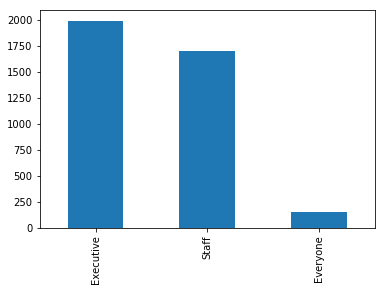

In [5]:
# What does our target variable look like?
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# get a feel for the distribution
newsdf['Audience'].value_counts().plot(kind='bar')

In [6]:
# a little preprocessing
import re
news_dict = {'united states':'usa','states':'state', 'years':'year',
             'new york': 'ny', 'republicans':'republican', 'schools':'school',
            'companies':'company'}

def multiple_replace(dict, text): 

  """ Replace in 'text' all occurences of any key in the given
  dictionary by its corresponding value.  Returns the new tring.""" 
  text = str(text).lower()

  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)

newsdf['cleantext'] = newsdf.text.apply(lambda x: multiple_replace(news_dict, x))


In [7]:
# create a custom stopwords list - I choose to start with the nltk list
from nltk.corpus import stopwords

nltk_stopwords = stopwords.words("english")

print(type(nltk_stopwords))
print(len(nltk_stopwords))
my_stopwords = nltk_stopwords + ["mr", "ms", "say","said", "0", '000','10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '200', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '21', '22', '23', '24', '25', '27', '30', '300', '35', '40', '45', '50', '500', '60', '70', '80']
print(len(my_stopwords))

<class 'list'>
153
196


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate vectorizer(s)
cv1 = CountVectorizer(lowercase=True, 
                     stop_words=my_stopwords,
                     binary=False,
                     max_df=0.95, 
                     min_df=0.05,
                     ngram_range = (1,2)) 


# fit and transform text
cv_dm = cv1.fit_transform(newsdf['cleantext'])

# print matrix shape(s)
print(cv_dm.shape)
names = cv1.get_feature_names()
print(type(names), len(names))

(3848, 1237)
<class 'list'> 1237


In [9]:
count = np.sum(cv_dm.toarray(), axis = 0).tolist()
print(type(count), len(count))
count_df = pd.DataFrame(count, index = names, columns = ['count'])

count_df.sort_values(['count'], ascending = False).head(20)

<class 'list'> 1237


,count
year,10314
one,8680
would,8627
like,6614
people,5547
new,5022
two,4899
time,4757
could,4620
also,4316


## Now let's try to build a model to predict the classification "Audience"

### First create the training and test datasets

In [10]:
# train test split
# data are X, labels are y
from sklearn.model_selection import train_test_split

X = cv_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
print(type(X), X[0:10])


y = newsdf['Audience'].values #this is an array of labels
print(type(y), y[0:10])

 

<class 'numpy.ndarray'> [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 0]]
<class 'numpy.ndarray'> ['Executive' 'Staff' 'Executive' 'Executive' 'Executive' 'Executive'
 'Staff' 'Staff' 'Everyone' 'Executive']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(2693, 1237)
(1155, 1237)
(2693,)
(1155,)


## Let's start with decision trees and take a look at what the tree actually shows.

In [12]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

# fit a logistic regression model to the data
model = DecisionTreeClassifier(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
0.581818181818
accuracy: 0.581818181818
             precision    recall  f1-score   support

   Everyone       0.12      0.09      0.10        58
  Executive       0.62      0.64      0.63       599
      Staff       0.58      0.57      0.57       498

avg / total       0.58      0.58      0.58      1155



In [13]:
from sklearn import tree
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=cv1.get_feature_names() ,  
                         class_names=newsdf.Audience.unique() ,  
                         filled=True, rounded=True,  
                         special_characters=True)  

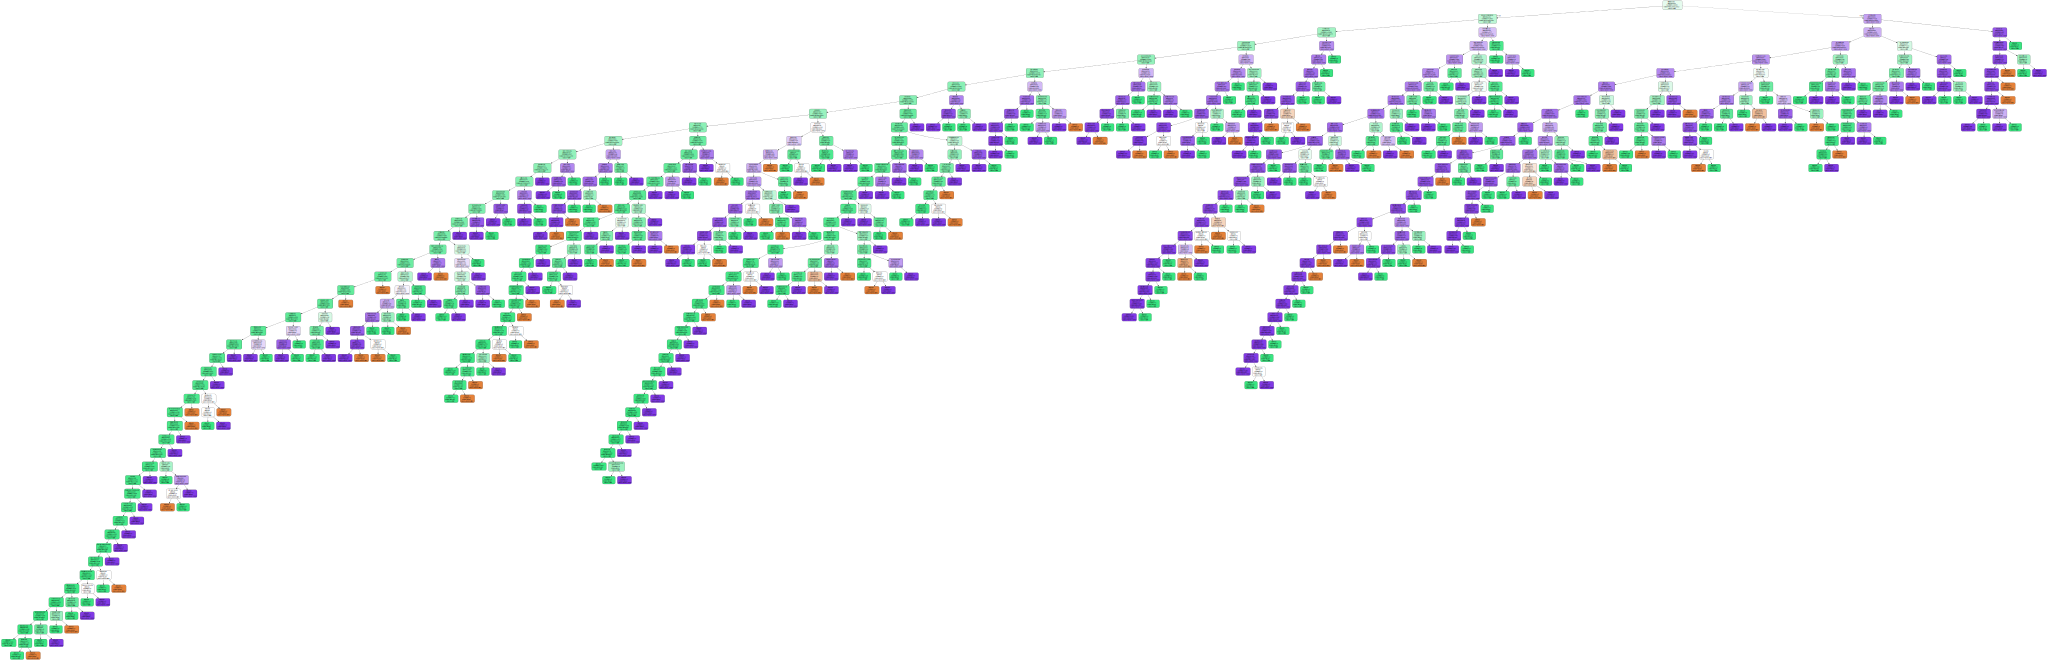

In [32]:
import graphviz 
graph = graphviz.Source(dot_data)  # creates the graph 
graph #renders the graph inline

In [32]:
# graph.render("Audience_tree") 
# this code writes the tree to a PDF file



## This is a HUGE tree.  In reality we would use some of the settings to prune it down.

## But decisions trees weren't the most accurate - let's use logistic regression for the actual prediction

In [33]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.698701298701
accuracy: 0.698701298701
             precision    recall  f1-score   support

   Everyone       0.25      0.07      0.11        58
  Executive       0.73      0.74      0.73       599
      Staff       0.68      0.72      0.70       498

avg / total       0.68      0.70      0.69      1155



### How do we use this model to predict?  Bring in new news


In [34]:
# Wall Street Journal
wsjnewsdf = pd.read_csv("wsjnews.csv") 

print(wsjnewsdf.shape)
print(list(wsjnewsdf))
wsjnewsdf.head()

(201, 5)
['Unnamed: 0', 'Unnamed: 0.1', 'date', 'text', 'likes']


,Unnamed: 0,Unnamed: 0.1,date,text,likes
0,0,0,12/31/14,"Gold prices ended down for second year in a row, weighed down by investors' expectations of higher U.S. interest rates and tame inflation around the world.</br></br>Gold for February delivery, the most actively traded contract, closed down $16.30, at $1,184.10 a troy ounce on the Comex division of the New York Mercantile Exchange. Prices fell 1.5% for the year.</br></br>A stronger dollar weighed on gold Wednesday, making the metal more expensive for buyers holding other currencies. The WSJ Dollar Index, which gauges the dollar against other major currencies, was recently up 0.4%, at 83.00.</br></br>""The way things stand, I would be looking to sell into any rallies from here,"" said Bob Haberkorn, a broker at RJO Futures. ""Gold will continue to be weak because of rate expectations.""</br></br>An improving U.S. economy has sparked expectations that the Federal Reserve will raise interest rates in 2015, a move that would hurt gold, which struggles to compete with yield-bearing investments in times of tighter monetary policy. At the same time, inflation has been elusive in the world's major economies, reducing gold's attractiveness as a hedge against rising consumer prices.",202.0
1,1,1,12/26/14,"Gold prices rose Friday, as investors locked in profits on bets for the precious metal's decline in a thinly traded market.</br></br>Gold for February delivery, the most actively traded contract, closed up $21.80, or 1.9%, at $1,195.30 a troy ounce on the Comex division of the New York Mercantile Exchange. It was the highest settlement since Dec. 19.</br></br>Prices for the precious metal are down 3% from December's highs, as a swiftly improving U.S. economy has raised concerns that the Federal Reserve will lift interest rates sooner than expected in 2015. Gold struggles to compete with yield-bearing investments when rates rise.</br></br>On Friday, some investors appeared to be buying gold to cover their bets on a decline in prices, while others were looking for bargains after the metal's drop, analysts said.</br></br>""Thin, postholiday trading conditions are likely exacerbating the bigger daily price move,"" said Jim Wyckoff, an analyst at Kitco.com, in a note to clients. ""Many traders and investors have checked out for the week, if not for the rest of the year.""",894.0
2,2,2,12/24/14,"The dollar gained against the yen and the euro on Tuesday after the U.S. economy grew at the fastest pace in 11 years, bolstering the market's expectations for higher interest rates.</br></br>The dollar increased 0.6% in late-afternoon trade to 120.77 yen, a two-week high. The euro pushed to a more than two-year low in early trade and was recently down 0.5% to $1.2169.</br></br>U.S. gross domestic product grew 5% in the third quarter, well above last month's estimate of 3.9%, the Commerce Department said Tuesday. It was the fastest pace since GDP grew 6.9% during the third quarter of 2003.</br></br>The GDP data encouraged investors who have been betting that a recovering U.S. economy would spur the Federal Reserve to raise interest rates before other major central banks do. Higher U.S. rates would bring more investors to the dollar, as they would increase returns on assets denominated in the currency.</br></br>""With 5% growth in the U.S. now, even if we don't improve at that pace next quarter, we're still light years ahead of the eurozone and Japan,"" said Joseph Quinlan, chief market strategist at U.S. Trust Private Wealth Management.",2202.0
3,3,3,12/23/14,"The dollar gained against the yen and the euro on Tuesday after the U.S. economy grew at , bolstering the market's expectations for higher interest rates.</br></br>The dollar increased 0.6% in late-afternoon trade to 120.77 yen, a two-week high. The euro pushed to a more than two-year low in early trade and was recently down 0.5% to $1.2169.</br></br>U.S. gross domestic product grew 5% in the third quarter, well above last month's estimate

In [22]:
## what prep do we need to do? What if we just vectorize the space as is? 

wsjcv_dm = cv1.fit_transform(wsjnewsdf['text'])#

print(wsjcv_dm.shape)

# that's not the same feature space that we had before so it won't work
wsjcv_predicted = model.predict(wsjcv_dm)



(201, 446)


ValueError: Number of features of the model must match the input. Model n_features is 1237 and input n_features is 446 

In [23]:
## need to create the counts for this space using the vocab from our first space
## remember, we captured our feature names with the list names
print(type(names))
print(len(names))


cvnews = CountVectorizer(lowercase=True, 
                     stop_words=my_stopwords,
                     binary=False,
                     max_df=0.95, 
                     min_df=0.05,
                     ngram_range = (1,2),
                     vocabulary = names) 


wsjcv_dm = cvnews.fit_transform(wsjnewsdf['text'])

print(wsjcv_dm.shape)

# that's not the same feature space that we had before so it won't work
#wsjcv_predicted = model.predict(wsjcv_dm)


<class 'list'>
1237
(201, 1237)


In [24]:
# now do our prediction

wsjcv_predicted = model.predict(wsjcv_dm)
print(wsjcv_predicted.shape)
print(wsjcv_predicted[0:10])

(201,)
['Executive' 'Executive' 'Executive' 'Executive' 'Staff' 'Staff'
 'Executive' 'Executive' 'Executive' 'Executive']


### Now we have our predicted labels.  Are the "right"?  In general we'll never know.  We know we used a model with around 70% accuracy so we would assume that prediction rate here.  


### Things to consider:
* We've forced this text to take on our specific feature space.  Therefore, we are getting the information about this text that conforms to our model.  If there are "important" tokens in the WSJ that are not part of our feature space, we are not capturing that. As we assumed in class, they are being ignored. 
* We haven't done the full preprocessing on the new text so we may not be getting a comparable count for some of our features:  "states" will still appear and will be ignored because it's not in our vocabulary and the count for "state" won't be comparable because we aren't adding in the reformed "state" items. 
* Depending on your compute power, timing for producing results, and level of complexity for the preprocessing, you may or may not take all the preparatory steps on the new data before running it through your model.  You will lose accuracy because you are not quite matching your current data to what the model expects but that might be okay.  

## What about adding external information to help with prediction?  

### We have data on "likes" - how do we use that?

In [19]:
# Add this column to our feature space - cv_dm
print(cv_dm.shape)

Xdf = pd.DataFrame(cv_dm.toarray())
Xdf['likes'] = np.transpose(newsdf.likes.values)

print(Xdf.shape)

(3848, 1237)
(3848, 1238)


In [37]:
print(list(newsdf))

['description', 'headline', 'url', 'text', 'cleantext', 'Audience', 'likes']


In [20]:
X = Xdf
Y = newsdf.Audience
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(2693, 1238)
(1155, 1238)
(2693,)
(1155,)


In [21]:
# Logistic Regression

# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.821645021645
accuracy: 0.821645021645
             precision    recall  f1-score   support

   Everyone       0.50      0.19      0.27        58
  Executive       0.82      0.84      0.83       599
      Staff       0.83      0.88      0.86       498

avg / total       0.81      0.82      0.81      1155



### Wow, in this case the number of "likes" increased our predictive power tremendously!

We should definitely use these data for our prediction.  Let's do that and see how much our predictions change.  

In [231]:
# Add this column to our feature space - cv_dm
print(wsjcv_dm.shape)

Wdf = pd.DataFrame(wsjcv_dm.toarray())
Wdf['likes'] = np.transpose(wsjnewsdf.likes.values)

print(Wdf.shape)

(201, 1237)
(201, 1238)


In [236]:
len(wsjnewsdf.likes.values)
print(wsjcv_dm.shape)

(201, 1237)


In [23]:
# now do our prediction

wsjcv2_predicted = model.predict(Wdf)
print(wsjcv_predicted.shape)
print(wsjcv_predicted[0:10])

(201,)
['Staff' 'Executive' 'Staff' 'Staff' 'Executive' 'Executive' 'Executive'
 'Staff' 'Staff' 'Staff']


### Does this make a difference?  Does it change many of the label assignments?

In [24]:
diff = np.where(wsjcv_predicted != wsjcv2_predicted)
print(len(diff[0]))

118


### Is this "right"?  

We don't know.  We don't know the truth.  We only know that we used all the information we had to make a prediction using a model that had about 80% accuracy.

### Predict number of likes

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate vectorizer(s)
cv1 = CountVectorizer(lowercase=True, 
                     stop_words=my_stopwords,
                     binary=False,
                     max_df=0.50, 
                     min_df=0.05,
                     ngram_range = (1,2)) 


# fit and transform text
cv_dm = cv1.fit_transform(newsdf['cleantext'])

# print matrix shape(s)
print(cv_dm.shape)
names = cv1.get_feature_names()
print(type(names), len(names))

(3848, 1223)
<class 'list'> 1223


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(use_idf=True, norm=None, stop_words = my_stopwords, 
                         min_df = 0.05, max_df = 0.50, ngram_range = (1,2)) #define the transformation
tfidf_dm = tfidf.fit_transform(newsdf['cleantext']) #apply the transformation
print(tfidf_dm.shape)
#tfidfVectororizerTable = pd.DataFrame(tf3_dm.toarray(), columns = tfidf3.get_feature_names())

(3848, 1223)


In [10]:
# train test split
# data are X, labels are y
from sklearn.model_selection import train_test_split

X = cv_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
print(type(X), X[0:10])

y = newsdf['likes'].values #this is an array of labels
print(type(y), y[0:10])

<class 'numpy.ndarray'> [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 0]]
<class 'numpy.ndarray'> [  648.  1060.  2025.  3739.  1286.  3662.   860.  1003.  4645.   884.]


In [11]:
np.percentile(newsdf['likes'], [0, 40, 90, 100])

array([     0. ,    793.8,   4107.3,  29910. ])

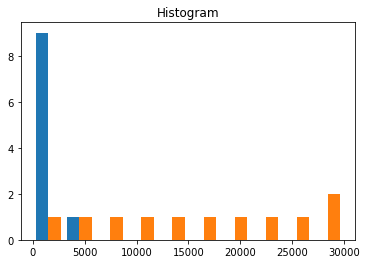

In [12]:
import matplotlib.pyplot as plt
a = np.histogram(newsdf['likes'])
plt.hist(a)  # arguments are passed to np.histogram
plt.title("Histogram")
plt.show()

In [13]:
from sklearn import preprocessing
import numpy as np

y_scaled = preprocessing.scale(newsdf['likes'])
newsdf['y_scaled'] = y_scaled

In [14]:
y_scaled.mean(axis=0)

2.3312375361151937e-17

In [15]:
y_scaled.std(axis=0)

1.0

In [16]:
np.percentile(y_scaled, [0, 40, 90, 100])

array([ -0.97165564,  -0.51097246,   1.41202288,  16.38666357])

In [33]:
y = pd.qcut(newsdf['likes'], 3, labels=["Low","Medium","high"])
from __future__ import division
def categorize(zValue):
    if (zValue > 1.41202288):
        likesCat = 'High'
    elif (zValue < -0.52267085):
        likesCat = 'Low'
    else:
        likesCat = 'Medium'
    return likesCat

y = newsdf['y_scaled'].apply(lambda x: categorize(x))
newsdf['y'] = y

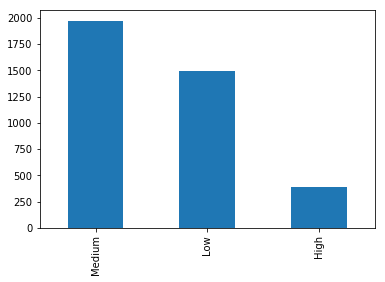

In [18]:
y.value_counts().plot(kind='bar')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(2693, 1223)
(1155, 1223)
(2693,)
(1155,)


In [20]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

# fit a logistic regression model to the data
model = DecisionTreeClassifier(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
0.458008658009
accuracy: 0.458008658009
             precision    recall  f1-score   support

       High       0.16      0.11      0.13       125
        Low       0.42      0.43      0.42       437
     Medium       0.53      0.55      0.54       593

avg / total       0.45      0.46      0.45      1155



In [34]:
from sklearn import tree
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=cv1.get_feature_names() ,  
                         class_names=newsdf.y.unique() ,  
                         filled=True, rounded=True,  
                         special_characters=True)  

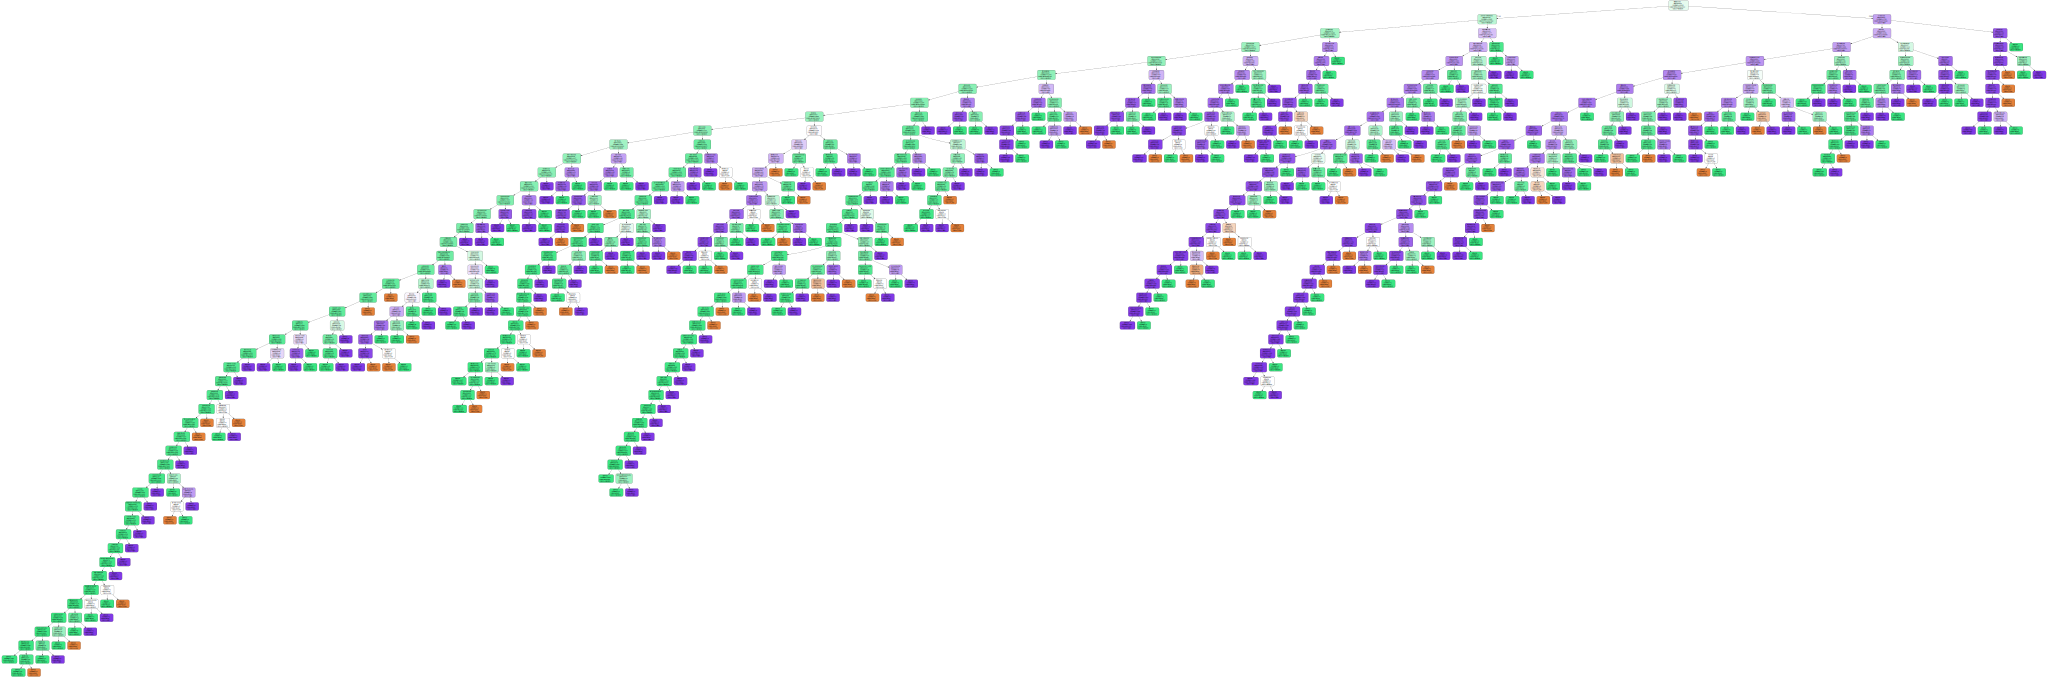

In [35]:
import graphviz 
graph = graphviz.Source(dot_data)  # creates the graph 
graph

In [25]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.474458874459
accuracy: 0.474458874459
             precision    recall  f1-score   support

       High       0.08      0.05      0.06       125
        Low       0.45      0.50      0.47       437
     Medium       0.55      0.55      0.55       593

avg / total       0.46      0.47      0.47      1155



In [26]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# fit a Naive Bayes model to the data
model = MultinomialNB()
print(model)
model.fit(X_train, y_train)

# make predictions
clf2_expected = y_test
clf2_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print(metrics.classification_report(clf2_expected, clf2_predicted))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
0.451948051948
accuracy: 0.451948051948
             precision    recall  f1-score   support

       High       0.16      0.28      0.20       125
        Low       0.49      0.48      0.49       437
     Medium       0.55      0.47      0.50       593

avg / total       0.48      0.45      0.46      1155



In [238]:
audience_with_dummies = pd.get_dummies(newsdf.Audience)
print(list(audience_with_dummies))
print(audience_with_dummies.shape)

['Everyone', 'Executive', 'Staff']
(51664, 3)


In [239]:
len(newsdf.Everyone.values)

51664

##### If we include the audience to the model the result is much better.

In [241]:
print(cv_dm.shape)

Xdf = pd.DataFrame(cv_dm.toarray())
Xdf['Everyone'] = np.transpose(newsdf.Everyone.values)
Xdf['Executive'] = np.transpose(newsdf.Executive.values)
Xdf['Staff'] = np.transpose(newsdf.Staff.values)
print(Xdf.shape)

(51664, 1195)
(51664, 1198)


In [250]:
X_train, X_test, y_train, y_test = train_test_split(Xdf, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(36164, 1198)
(15500, 1198)
(36164,)
(15500,)


In [251]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.932580645161
accuracy: 0.932580645161
             precision    recall  f1-score   support

       High       0.97      0.92      0.94      1627
        Low       0.85      0.64      0.73      1853
     Medium       0.94      0.98      0.96     12020

avg / total       0.93      0.93      0.93     15500

